# Positional Encoders

A small disclaimer that the ensuing discuussion is merely some form of sanity/understanding check with the generated code. For imagination/visualization purposes, positional encoders for words/sentences is made use of as an example.

Positional encoders provide information regarding a, for example, word's place in a sentence. In order to introduce order, the easiest way might be to introduce some integer or number that says about a word's position, e.g., for a sentence "The quick brown fox jumped over the lazy dog", the position of "The" would be 0 and the position of "jumped" would be 4. However, the problem with this is that this number might get too large, and it might not scale well.

Another solution might be to "map" words from [0, 1], with each step in between words being equidistant. However, this can also provide some difficulties in that varied length of sentences will produce wildly different results, i.e., if mapping is done from [0, 1], the difference between "positions" in sentences with varying lengths will not be the same, and finding the length of the sentence will also be difficult in this case.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_rad_list(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  res = pos * angle_rates
  return res

The formula for calculating positional encodings, as described in the Attention Is All You Need paper, makes use of:

*   PE(pos, 2i) = sin(pos / 10000^(2i / d))
*   PE(pos, 2i + 1) = cos(pos / 10000^(2i / d))

This could also, quite possibly, be looked at as:

*   PE(pos, 2i) = sin(omega \* t)
*   PE(pos, 2i + 1) = cos(omega \* t)

Where t is the position (time and position can be seen as quite similar for this case), and omega pertains to the frequency.

The assignment requires that the domain of 16-dim is distributed between 0 and 2*pi.

This approach is taken: instead of making use directly of the position, makes use of [0, ..., 2\*pi] in such a manner that this array will have a length equal to the maximum position value (16 in this case). In replacing pos with this array, the value of the variables to be passed to the sine functions is limited from 0 to 2\*pi.

Another possible interpretation might be that it's omega that needs to be from 0 to 2\*pi, i.e., pos is kept as is.

In [3]:
def positional_encoding(position, d_model):
  v_pos = np.linspace(0, 2 * np.pi, num=d_model)[:, np.newaxis]
  v_dim = np.arange(d_model)[np.newaxis, :]
  rad_list = get_rad_list(v_pos, v_dim, d_model)

  # apply sin() to even
  rad_list[:, 0::2] = np.sin(rad_list[:, 0::2])

  # apply cos() to odd
  rad_list[:, 1::2] = np.cos(rad_list[:, 1::2])

  return rad_list[np.newaxis, ...]

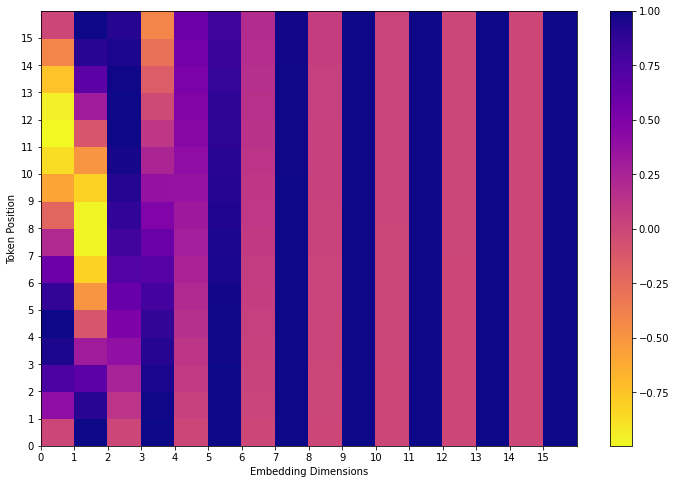

In [12]:
tokens = 16
dimensions = 16

pos_encoding = positional_encoding(tokens, dimensions)

plt.figure(figsize=(12,8))
plt.pcolormesh(pos_encoding[0], cmap='plasma_r')

plt.xlabel('Embedding Dimensions')
plt.xlim((0, dimensions))
plt.xticks(np.arange(0, dimensions, step=1))

plt.ylabel('Token Position')
plt.ylim((0, tokens))
plt.yticks(np.arange(0, tokens, step=1))

plt.colorbar()
plt.show()

If the functions Bt (B subscript t, where t is the position) are basis vectors, their orthogonality and orthonormality are then checked.

One of the properties of an orthogonal square matrix is that when the matrix and its transpose are multiplied, the resulting matrix should be an identity matrix, that is, if the columns of the matrix are orthonormal.

In [5]:
def check_orthogonal_matrix(matrix):
  # This will throw an error if it's not a square matrix
  assert matrix.shape[1] == matrix.shape[2]

  matrix_res = matrix @ matrix.T

  matrix_id = np.eye(N=matrix.shape[1], M=matrix.shape[2])
  matrix_id = np.expand_dims(matrix_id, 2)

  check_if_res_id_eq = np.all(np.equal(matrix_res, matrix_id))
  # print(f"Is matrix * matrix_transpose = identity? {'Yes' if check_if_res_id_eq else 'No'}")

  matrix_inv = np.linalg.inv(matrix)

  check_if_inv_t_eq = np.all(np.equal(matrix_inv, matrix.T))
  # print(f"Is matrix_inverse = matrix_transpose? {'Yes' if check_if_inv_t_eq else 'No'}")

  return check_if_res_id_eq and check_if_inv_t_eq

In [6]:
print(f"Is the matrix orthogonal? {'Yes' if check_orthogonal_matrix(pos_encoding) else 'No'}")

Is the matrix orthogonal? No


From the quick check above, it seems that the basis vectors (found in `pos_encoding`) are not orthogonal and orthonormal.

The Gram-Schmidt Process is used to get the orthonormal basis vectors.

Two approaches can be found below. One makes use of a more manual computation, and the other makes use of QR decomposition.

In [7]:
def gs_process(orig_matrix):
  matrix = np.copy(orig_matrix)
  matrix = np.squeeze(matrix, axis=0)

  # This will throw an error if it's not a square matrix
  assert matrix.shape[0] == matrix.shape[1]

  for i in range(1, matrix.shape[1]):
    for j in range(i):
      matrix[:, i] -= np.dot(matrix[:, j], matrix[:, i])/np.dot(matrix[:, j], matrix[:, j]) * matrix[:, j]
    matrix[:, i] /= np.linalg.norm(matrix[:, i])

  return np.expand_dims(matrix, axis=0)

In [8]:
def gs_qr(orig_matrix):
  matrix = np.copy(orig_matrix)
  matrix = np.squeeze(matrix, axis=0)

  # This will throw an error if it's not a square matrix
  assert matrix.shape[0] == matrix.shape[1]

  Q, R = np.linalg.qr(matrix)

  return np.expand_dims(Q, axis=0)

Seen in the graph below are the now orthonormal basis vectors in position encoding.

When trying out a higher valued token and dimension (e.g., 32 x 32 dim), it appears to have some form of pattern that's a mirror of the original pos_encoding matrix. After a depth of 16, or near 16, this pattern appears to disappear for the orthonormal basis.

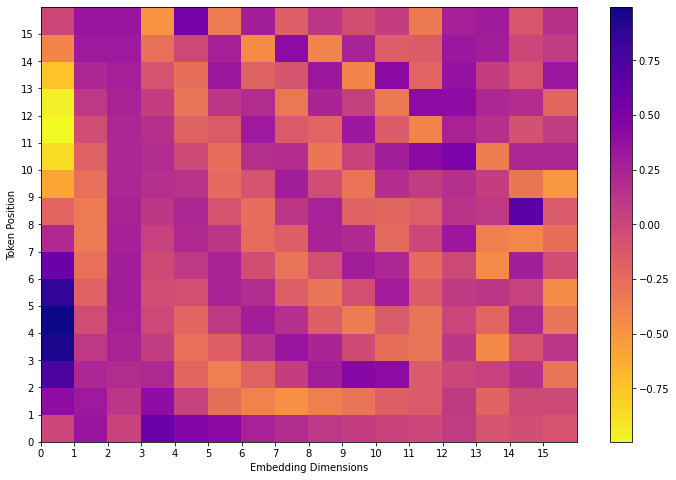

In [13]:
gs_b = gs_process(pos_encoding)

plt.figure(figsize=(12,8))
plt.pcolormesh(gs_b[0], cmap='plasma_r')

plt.xlabel('Embedding Dimensions')
plt.xlim((0, dimensions))
plt.xticks(np.arange(0, dimensions, step=1))

plt.ylabel('Token Position')
plt.ylim((0, tokens))
plt.yticks(np.arange(0, tokens, step=1))

plt.colorbar()
plt.show()